# Wine Rating Data Exploration

With these next steps we will explore the dataset at hand, converting the columns for better input the dataset into predictive algorithms.
The dataset has been split 70-30 instead of the original 90-10 in order to better control variance in performance measures (given the relatively small dataset available for the challenge).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import scipy
import numpy as np
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Train and test set are combined for data analysis.

Since this is a sample dataset, all the operations on categorical data must take into account additional possible values.

In [2]:
# train = pd.read_csv('../data_root/split/train.csv')
# test = pd.read_csv('../data_root/split/test.csv')
# df = pd.concat([train, test], ignore_index=True)
df = pd.read_csv('../data_root/split/train.csv')

In [3]:
df.sample(10)  # [['title', 'designation', 'description', 'variety']]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
6684,US,"A proprietary blend of 85% Cabernet Sauvignon,...",Zephyr Private Reserve,91,85.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Davis Estates 2012 Zephyr Private Reserve Red ...,Bordeaux-style Red Blend,Davis Estates
6702,US,One of a string of great values made at Terrav...,NaN,90,10.0,California,California,California Other,Jim Gordon,@gordone_cellars,Cookies & Cream 2010 Merlot (California),Merlot,Cookies & Cream
338,Chile,"Spicy cherry, blackberry, tobacco, tar and oak...",El Alto,90,45.0,Colchagua Valley,NaN,NaN,Michael Schachner,@wineschach,Alto Los Romeros 2012 El Alto Red (Colchagua V...,Red Blend,Alto Los Romeros
7482,US,"A delicious Zinfandel, one of Fritz's best in ...",Estate,91,25.0,California,Dry Creek Valley,Sonoma,NaN,NaN,Fritz 2009 Estate Zinfandel (Dry Creek Valley),Zinfandel,Fritz
7882,Austria,They could make anything into dessert wine in ...,Eiswein,91,NaN,Burgenland,NaN,NaN,Roger Voss,@vossroger,Höpler 2009 Eiswein Pinot Noir (Burgenland),Pinot Noir,Höpler
5289,US,Barrel-fermented and blended with a splash of ...,NaN,87,24.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Bougetz 2013 Sauvignon Blanc (Napa Valley),Sauvignon Blanc,Bougetz
1130,US,Another small-production stunner from Terre Ro...,Monarch Mine Vineyard,92,30.0,California,Sierra Foothills,Sierra Foothills,Virginie Boone,@vboone,Terre Rouge 2008 Monarch Mine Vineyard Syrah (...,Syrah,Terre Rouge
4067,US,"This pretty wine is rich, dry and softly tanni...",Maestro Collection Ranch No. 2,92,65.0,California,Napa Valley,Napa,NaN,NaN,Beaulieu Vineyard 2009 Maestro Collection Ranc...,Cabernet Sauvignon,Beaulieu Vineyard
1624,US,This is Barlow's Bordeaux blend. Based on Cabe...,Barrouge,90,40.0,California,Napa Valley,Napa,NaN,NaN,Barlow 2005 Barrouge Red (Napa Valley),Bordeaux-style Red Blend,Barlow
5516,Portugal,"An elegant wine, its acidity showing through b...",Presidential Late Bottled Vintage,87,23.0,Port,NaN,NaN,Roger Voss,@vossroger,C. da Silva 2004 Presidential Late Bottled Vin...,Port,C. da Silva


## Data processing
We will process data with 2 goals in mind:
* keep the cardinality under control
* substitute the missing values with most coherent ones

### Missing Values and Cardinalities

From looking at some random points from the dataset, we can see that it contains missing values. 
We want to have an idea on how many are missing:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                7947 non-null   object 
 1   description            7953 non-null   object 
 2   designation            5699 non-null   object 
 3   points                 7953 non-null   int64  
 4   price                  7403 non-null   float64
 5   province               7947 non-null   object 
 6   region_1               6615 non-null   object 
 7   region_2               3069 non-null   object 
 8   taster_name            6350 non-null   object 
 9   taster_twitter_handle  6064 non-null   object 
 10  title                  7953 non-null   object 
 11  variety                7953 non-null   object 
 12  winery                 7953 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 807.9+ KB


In [5]:
df.isnull().sum().sort_values()

description                 0
points                      0
title                       0
variety                     0
winery                      0
country                     6
province                    6
price                     550
region_1                 1338
taster_name              1603
taster_twitter_handle    1889
designation              2254
region_2                 4884
dtype: int64

Luckily all the values in the target column for this task (`points`) are non-empty, so we don't have to discard any row. Also `title`, `description`, `variety` and `winery` don't have any missing value. We will explore the other variables to find ways to populate the missing values. If it is not possible to do that in a meaningful way, the variables will just be discarded.

We then check the cardinality of each of the variables at hand, and decide what to do with variables that have too many possible variable, which would make the training of a model unstable and unreliable.

In [6]:
object_columns = df.select_dtypes(include="object").columns

for column in object_columns:
    print(f"Variable '{column}' has cardinality {df[column].nunique()}")

Variable 'country' has cardinality 35
Variable 'description' has cardinality 7953
Variable 'designation' has cardinality 4417
Variable 'province' has cardinality 231
Variable 'region_1' has cardinality 685
Variable 'region_2' has cardinality 17
Variable 'taster_name' has cardinality 18
Variable 'taster_twitter_handle' has cardinality 14
Variable 'title' has cardinality 7943
Variable 'variety' has cardinality 300
Variable 'winery' has cardinality 4700


### Reducing number of possible values for high cardinality variables

Variables `description`, `designation`, `title` and `winery` have a very high cardinality, and must be reduced. Otherwise the number of feature used to train the model will be higher than the number of points, resulting in unstable predictions.

We see that title in many cases contains the year of the wine. We can extract that to transform a categorical variable in an easier to use integer numerical one.

In [7]:
years = [float('nan') for _ in range(len(df['title']))]
for i, title in enumerate(df['title']):
    # Find 4 consecutive digits in the title's text
    matched_years = re.findall(r"\d{4}", title)
    for year in matched_years:
        # Only use numbers that might actually be wine years
        if year[:2] in ['18', '19', '20']: 
            years[i] = int(year)
        
df['year'] = years

In order to decrease the cardinality of the description variable, the tf-idf algorithm was used to extract the 100 most important important words to a description in the collection of all reviews.

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=True, max_features=100)
description_features = vectorizer.fit_transform(df['description'])
# print(vectorizer.get_feature_names())

dense_features = pd.DataFrame(description_features.toarray())
dense_features.columns = [f"desc_{name}" for name in vectorizer.get_feature_names()]
df = pd.concat([df, dense_features], axis=1)
print(df.info())
print(df.isnull().sum().sort_values())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Columns: 114 entries, country to desc_years
dtypes: float64(102), int64(1), object(11)
memory usage: 6.9+ MB
None
desc_herb                   0
desc_pepper                 0
desc_pear                   0
desc_peach                  0
desc_palate                 0
                         ... 
region_1                 1338
taster_name              1603
taster_twitter_handle    1889
designation              2254
region_2                 4884
Length: 114, dtype: int64


It looks like `taster_name` and `taster_twitter_handle` are collinear variables.
In order to check if that is true, we count how many taster twitter are linked to each taster name, and vice versa:

In [9]:
tasters_twitter: dict = {}
twitters_taster: dict = {}
    
for name, twitter in zip(df["taster_name"], df["taster_twitter_handle"]):
    # Create a dict with a set containing all the twitter accounts connected to a name
    if not tasters_twitter.get(name):
        tasters_twitter[name] = {twitter}
    else:
        tasters_twitter[name].add(twitter)
    # Create a dict with a set containing all the names connected to a twitter account
    if not twitters_taster.get(twitter):
        twitters_taster[twitter] = {name}
    else:
        twitters_taster[twitter].add(name)

print("Twitter accounts connected to each taster")
pprint(tasters_twitter)
print("\nTaster names connected to each twitter account")
pprint(twitters_taster)

Twitter accounts connected to each taster
{nan: {nan},
 'Alexander Peartree': {nan},
 'Anna Lee C. Iijima': {nan},
 'Anne Krebiehl\xa0MW': {'@AnneInVino'},
 'Carrie Dykes': {nan},
 'Fiona Adams': {'@bkfiona'},
 'Jeff Jenssen': {'@worldwineguys'},
 'Jim Gordon': {'@gordone_cellars'},
 'Joe Czerwinski': {'@JoeCz'},
 'Kerin O’Keefe': {'@kerinokeefe'},
 'Lauren Buzzeo': {'@laurbuzz'},
 'Matt Kettmann': {'@mattkettmann'},
 'Michael Schachner': {'@wineschach'},
 'Mike DeSimone': {'@worldwineguys'},
 'Paul Gregutt': {'@paulgwine\xa0'},
 'Roger Voss': {'@vossroger'},
 'Sean P. Sullivan': {'@wawinereport'},
 'Susan Kostrzewa': {'@suskostrzewa'},
 'Virginie Boone': {'@vboone'}}

Taster names connected to each twitter account
{nan: {'Alexander Peartree', nan, 'Carrie Dykes', 'Anna Lee C. Iijima'},
 '@AnneInVino': {'Anne Krebiehl\xa0MW'},
 '@JoeCz': {'Joe Czerwinski'},
 '@bkfiona': {'Fiona Adams'},
 '@gordone_cellars': {'Jim Gordon'},
 '@kerinokeefe': {'Kerin O’Keefe'},
 '@laurbuzz': {'Lauren Buzz

We can see that there are few tasters that share a twitter account, and some others that don't have one. We will model this, by introducing a new variable for twitter, containing either "personal" if only one person is linked to the twitter account, "missing" if the taster doesn't have twitter, or the name of the twitter profile if more than one person use the same twitter account. 

In [10]:
for name, twitter_set in tasters_twitter.items():
    if str(name) == "nan":
        continue
    twitter = str(list(twitter_set)[0])
    if str(twitter) == "nan":
        continue
    if len(twitters_taster[twitter]) == 1:
        df.loc[df["taster_name"] == name, "taster_twitter_handle"] = "personal"
        

### Populating empty values

We will check if, for the few data points where country and province are missing, the information can be inferred in any way from other variables

In [11]:
missing_country_indices = df[df['country'].isnull()].index
df[df['country'].isnull()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,desc_texture,desc_toast,desc_tobacco,desc_touch,desc_vanilla,desc_vineyard,desc_white,desc_wine,desc_wood,desc_years
1868,NaN,"Almost caramel in color, this wine offers arom...",Babaneuri Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.271141,0.0,0.0,0.132966,0.0,0.0
1913,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Roger Voss,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.210480,0.0,0.0
6152,NaN,"Amber to the eye, this wine features an entici...",Dry Unfiltered Rkatsiteli Mtsvane,88,25.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.398451,0.000000,0.0,0.0,0.187000,0.0,0.0
6330,NaN,Made from 100% Melnick this garnet-colored win...,Nobile,88,23.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.391303,0.000000,0.000000,0.0,0.0,0.160748,0.0,0.0
6796,NaN,Basic cherry aromas turn more earthy and soupy...,Reserva Estate Bottled,85,12.0,NaN,NaN,NaN,Michael Schachner,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
7862,NaN,This wine is made from grapes grown in the Lak...,Márga,89,18.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.254784,0.0,0.0,0.124944,0.0,0.0


For some wines, the winery is available, but country, province and region are not.

If the same winery has any other wine in the dataset, we can use that to fill the gap, assuming a winery is linked to a specific country.

In [12]:
for winery in df[df['country'].isnull()]['winery']:
    # Search for wines from the same winery
    wines_same_winery = df[df['winery'] == winery][df['country'].notna()]
    if wines_same_winery.empty:
        print(f"No other wines found for winery '{winery}'")
    else:
        # Take the country from a wine from the same winery
        country = wines_same_winery['country'].iloc[0]
        
        # Assign it to the wines without a country
        df.loc[(df['country'].isnull()) & (df['winery'] == winery), "country"] = country
        
        # If the wines have a province, use it also to fill in the missing ones.
        if not wines_same_winery['province'].empty:
            region = wines_same_winery['province'].iloc[0]
            df.loc[(df['province'].isnull()) & (df['winery'] == winery), "province"] = region
        
        # If the wines have a province, use it also to fill in the missing ones.
        if not wines_same_winery['region_1'].empty:
            region = wines_same_winery['region_1'].iloc[0]
            df.loc[(df['region_1'].isnull()) & (df['winery'] == winery), "region_1"] = region

No other wines found for winery 'Gotsa Family Wines'
No other wines found for winery 'Gotsa Family Wines'
No other wines found for winery 'Logodaj'
No other wines found for winery 'St. Donat'


/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


We check now what of these data point null entries are added:

In [13]:
df.iloc[missing_country_indices]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,desc_texture,desc_toast,desc_tobacco,desc_touch,desc_vanilla,desc_vineyard,desc_white,desc_wine,desc_wood,desc_years
1868,NaN,"Almost caramel in color, this wine offers arom...",Babaneuri Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.271141,0.0,0.0,0.132966,0.0,0.0
1913,France,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,Languedoc-Roussillon,Vin de Pays d'Oc,NaN,Roger Voss,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.210480,0.0,0.0
6152,NaN,"Amber to the eye, this wine features an entici...",Dry Unfiltered Rkatsiteli Mtsvane,88,25.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.398451,0.000000,0.0,0.0,0.187000,0.0,0.0
6330,NaN,Made from 100% Melnick this garnet-colored win...,Nobile,88,23.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.391303,0.000000,0.000000,0.0,0.0,0.160748,0.0,0.0
6796,Chile,Basic cherry aromas turn more earthy and soupy...,Reserva Estate Bottled,85,12.0,Maule Valley,NaN,NaN,Michael Schachner,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
7862,NaN,This wine is made from grapes grown in the Lak...,Márga,89,18.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.254784,0.0,0.0,0.124944,0.0,0.0


In order to fill up the remaining values, we use the country, province and region from the same taster, starting from the assumption that a taster tastes mostly wines from the same area.

In [14]:
for taster in df[df['country'].isnull()]['taster_name']:
    # Take all the reviews from the taster that have country and province
    reviews_same_taster = df[df['taster_name'] == taster][(df['country'].notna())&(df['province'].notna())]
    # Count the number of reviews for each province
    reviews_per_province = reviews_same_taster.groupby(['province'])['country'].count()
    # Identify province with most reviews
    most_reviews_single_province = max(reviews_per_province)
    for province, count in reviews_per_province.to_dict().items():
        if count == most_reviews_single_province:
            # Assume the same province is from the same country
            df.loc[(((df['country'].isna()) | (df['province'].isna()))&df['taster_name'] == taster), "province"] = province
            country = reviews_same_taster[reviews_same_taster["province"]==province]["country"].iloc[0]
            df.loc[(((df['country'].isna()) | (df['province'].isna()))&df['taster_name'] == taster), "country"] = country
            break

/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='price'>

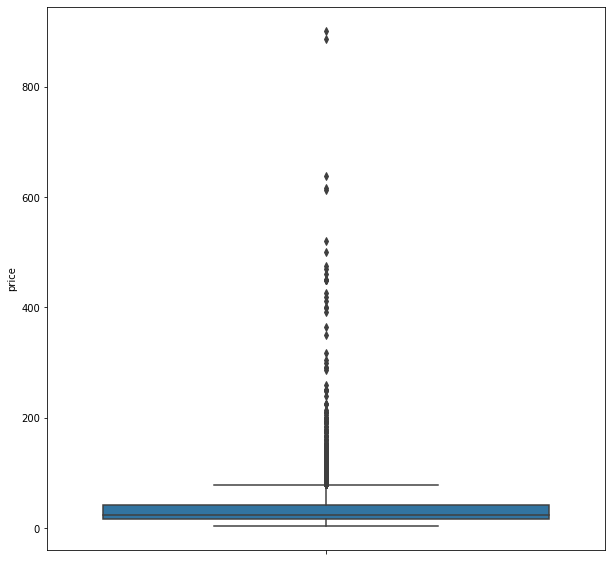

In [15]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="price", orient="v")

<AxesSubplot:xlabel='price', ylabel='Count'>

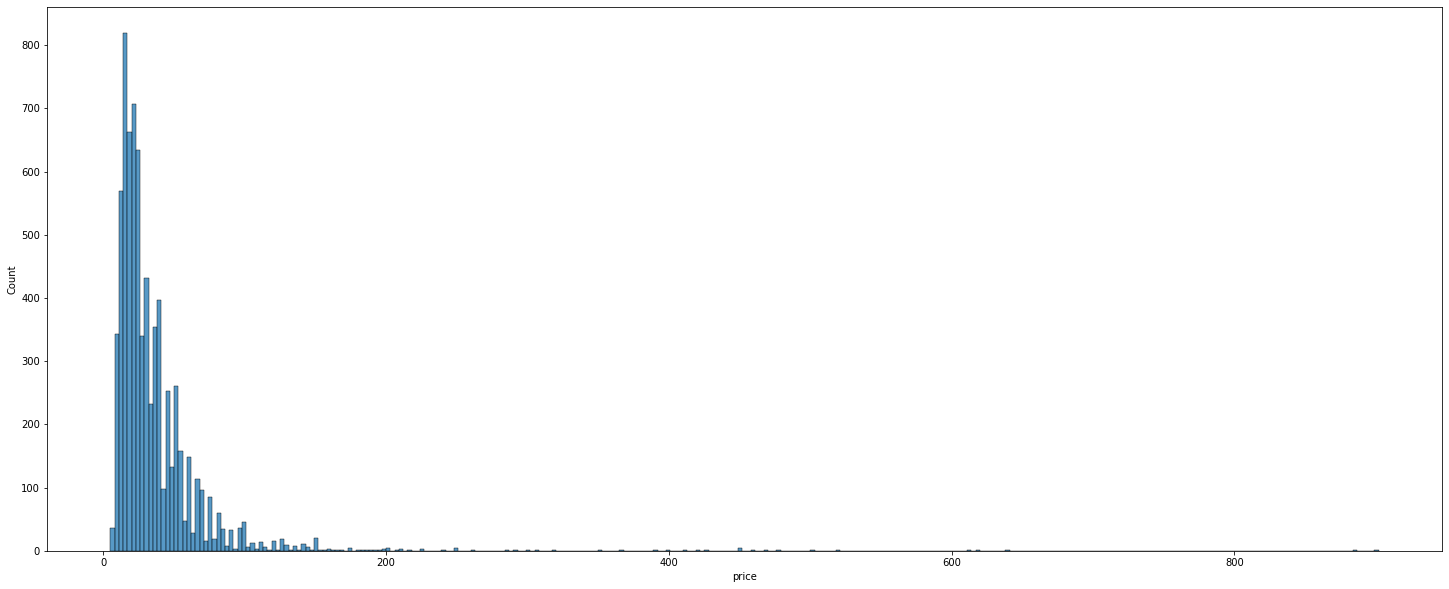

In [16]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="price", binwidth = 3)

Both the boxplot and the histogram of the price, show that it has a distribution skewed closed to 0, with some very expensive wines as outliers.

We want to check how price and the score given to the wine are correlated.
The price is limited to 100 in order to exclude outliers from the visualization.

The scatterplot and the pearson correlation coefficient shows some correlation, so we can expect the price to be a good predictor for the points assigned to the wine. 

,points,price
points,1.000000,0.447162
price,0.447162,1.000000


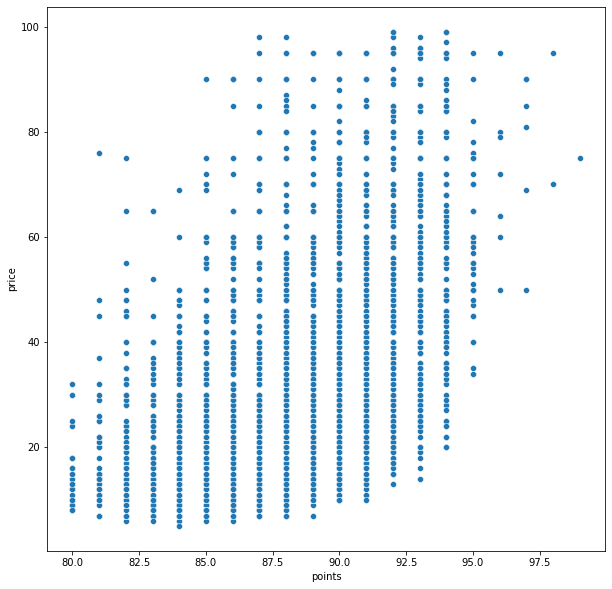

In [17]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df[df["price"]<100], x="points", y="price")
df[["points", "price"]].corr(method="pearson")

<AxesSubplot:xlabel='year', ylabel='Count'>

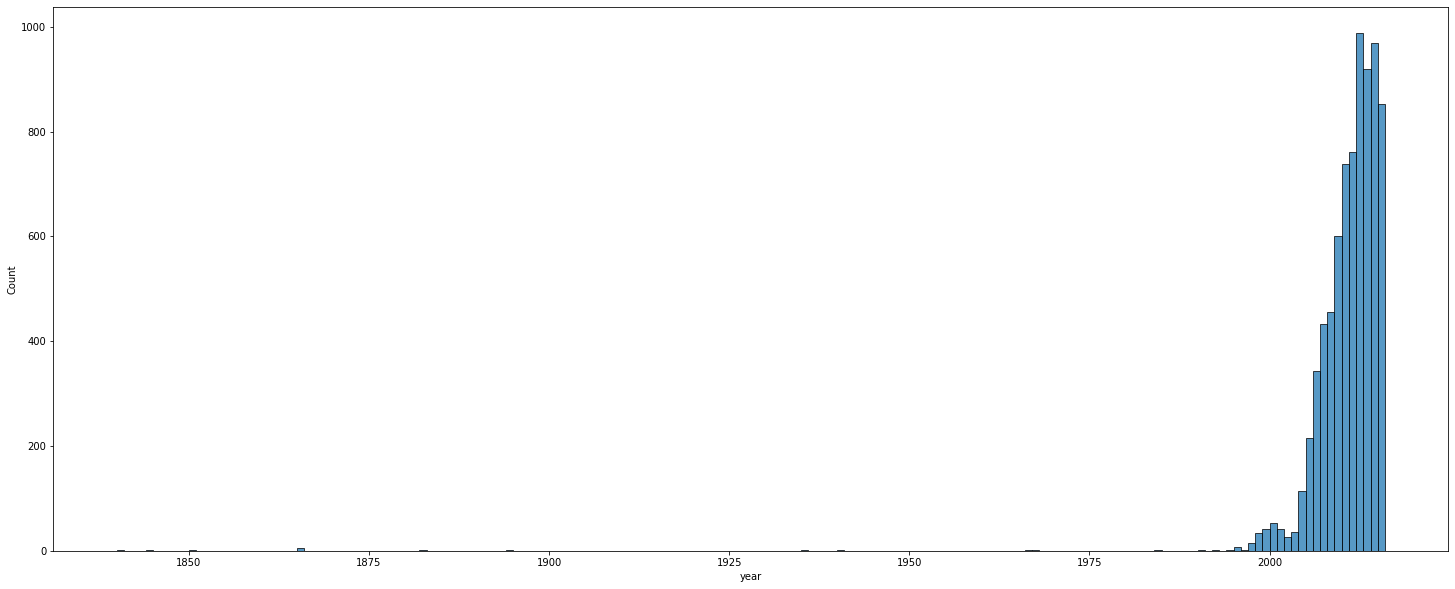

In [18]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="year", binwidth = 1)

The other only numerical variable is year, for which we also check the correlation and scatterplot.
The year is above 1975 in order to exclude outliers from the visualization.

This time the correlation is almost non-existent, so we don't expect this variable alone to have a lot of predictive power over the score of a wine.

,points,year
points,1.000000,0.025313
year,0.025313,1.000000


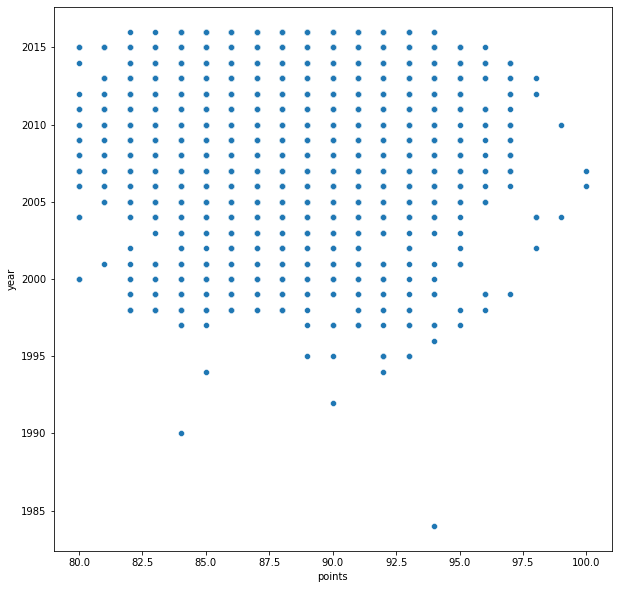

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df[df["year"]>1975], x="points", y="year")
df[["points", "year"]].corr(method="pearson")

We fill the empty values for numerical columns with the median, so that outliers do not impact too much on the assigned value.

We notice that `region_2` is present only for US wines. Hence we populate the empty values with the string `not_US`

In [20]:
df["year"] = df["year"].fillna(df["year"].median())
df["price"] = df["price"].fillna(df["price"].median())
df['region_2'] = df['region_2'].fillna("not_US")
df['region_1'] = df['region_1'].fillna("unknown")
df['taster_name'] = df['taster_name'].fillna("unknown")
df['taster_twitter_handle'] = df['taster_twitter_handle'].fillna("missing")

Since the description column has been modeled, we can drop it. We also drop the title, which we used to extract the year, and designation, which has high cardinality, high number of empty values.

In [21]:
df = df.drop(columns=['description', 'designation', 'title', 'winery'])

In [22]:
object_columns = df.select_dtypes(include="object").columns
for column in object_columns:
    print(f"Variable '{column}' has cardinality {df[column].nunique()}")

Variable 'country' has cardinality 35
Variable 'province' has cardinality 231
Variable 'region_1' has cardinality 686
Variable 'region_2' has cardinality 18
Variable 'taster_name' has cardinality 19
Variable 'taster_twitter_handle' has cardinality 3
Variable 'variety' has cardinality 300


<AxesSubplot:xlabel='points', ylabel='Count'>

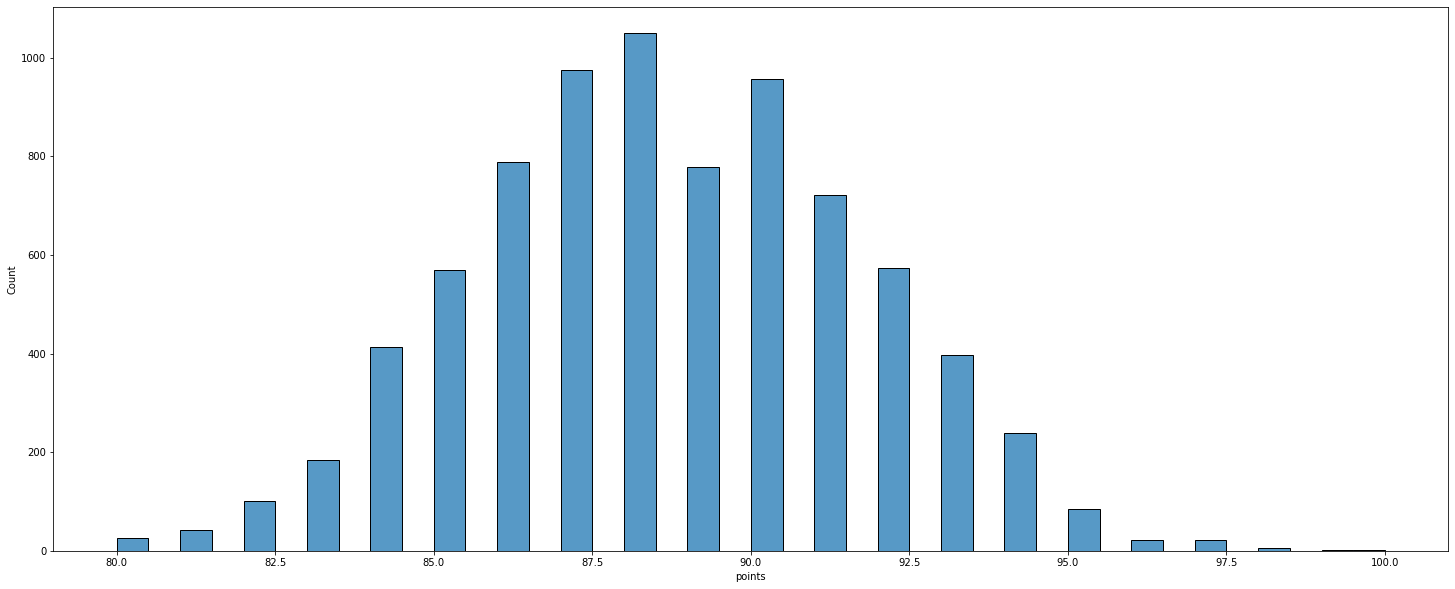

In [23]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="points")

We finally note how the score that we want to predict follows nicely the normal distribution, which we can use later to define a baseline.

## Train-Validation split

In [39]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [40]:
train_x, val_x, train_y, val_y = train_test_split(df, df[['points']], test_size=0.15,
                                     random_state=42,
                                     stratify=df[['points']])
train_x = train_x.drop(columns=['points'])
val_x = val_x.drop(columns=['points'])

In [44]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(train_x, train_y)
pred_val_y = dummy_regr.predict(val_x)
print(mean_squared_error(val_y, pred_val_y))
print(dummy_regr.score(val_x, val_y))

9.366303436714166
-0.023392204348912315


In [52]:
mean, var  = scipy.stats.distributions.norm.fit(train_y)
pred_val_y = []
for _ in range(len(val_x)):
    pred_val_y.append(np.random.normal(loc=mean, scale=var))
print(mean_squared_error(val_y, pred_val_y))
# print(dummy_regr.score(val_x, val_y))

18.54848721614977
